In [10]:
import pandas as pd
import numpy as np
import joblib

# Load the datasets and scaler
NO3_train = pd.read_csv('preprocessed_datasets/NO3_train.csv')
NO3_val = pd.read_csv('preprocessed_datasets/NO3_val.csv')
NO3_test = pd.read_csv('preprocessed_datasets/NO3_test.csv')
NO3scaler = joblib.load('preprocessed_datasets/NO3scaler.pkl')

NO3_train.head()

,timestamp,consumption,temperature,time_of_day,time_of_week,time_of_year,lag_24_hours,lag_1_hour
0,2017-05-02 00:00:00+00:00,0.227701,0.450877,0.000000,0.166667,0.331507,0.246874,0.236276
1,2017-05-02 01:00:00+00:00,0.222187,0.450877,0.043478,0.166667,0.331507,0.248087,0.227701
2,2017-05-02 02:00:00+00:00,0.226947,0.443860,0.086957,0.166667,0.331507,0.248142,0.222187
3,2017-05-02 03:00:00+00:00,0.236823,0.431579,0.130435,0.166667,0.331507,0.250252,0.226947
4,2017-05-02 04:00:00+00:00,0.287226,0.426316,0.173913,0.166667,0.331507,0.268047,0.236823


In [11]:

NO3_train = NO3_train.drop(['timestamp'], axis=1)
NO3_val = NO3_val.drop(['timestamp'], axis=1)
NO3_test = NO3_test.drop(['timestamp'], axis=1)

# Splitting the datasets into features and targets and converting them into numpy arrays

# Separate features and targets for the training set
NO3_train_x = NO3_train.drop('consumption', axis=1).to_numpy(dtype=np.float32)
NO3_train_y = NO3_train['consumption'].to_numpy(dtype=np.float32)

# Separate features and targets for the validation set
NO3_val_x = NO3_val.drop('consumption', axis=1).to_numpy(dtype=np.float32)
NO3_val_y = NO3_val['consumption'].to_numpy(dtype=np.float32)

# Separate features and targets for the test set
NO3_test_x = NO3_test.drop('consumption', axis=1).to_numpy(dtype=np.float32)
NO3_test_y = NO3_test['consumption'].to_numpy(dtype=np.float32)

In [12]:
# Process the dataset NO3_train so that it can be fed into the RNN, having 3D shape, dimensions (samples, timesteps, features) = (40920, 24, 4)

# Function to add the lagged features to the dataset
import numpy as np

def temporalize(X, y, lookback, prediction_horizon):
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - prediction_horizon):
        t = []
        for j in range(1, lookback + 1):
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        # Modify this line to include the next 24 values as a sequence
        output_y.append(y[i + lookback + 1 : i + lookback + 1 + prediction_horizon])
    return np.squeeze(np.array(output_X)), np.array(output_y).reshape(-1, prediction_horizon, 1)

# Temporalize the data
lookback = 24
prediction_horizon = 1  # Predicting 24 hours forward
NO3_train_x, NO3_train_y = temporalize(NO3_train_x, NO3_train_y, lookback, prediction_horizon)
NO3_val_x, NO3_val_y = temporalize(NO3_val_x, NO3_val_y, lookback, prediction_horizon)
NO3_test_x, NO3_test_y = temporalize(NO3_test_x, NO3_test_y, lookback, prediction_horizon)

# Check the shape of the datasets
print(NO3_train_x.shape, NO3_train_y.shape)



(40895, 24, 6) (40895, 1, 1)


In [13]:
NO3_train_x.shape

(40895, 24, 6)

Epoch 1/80


c:\Users\maxgu\Projects\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0551 - val_loss: 0.0132
Epoch 2/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0112 - val_loss: 0.0068
Epoch 3/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0091 - val_loss: 0.0192
Epoch 4/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0076 - val_loss: 0.0155
Epoch 5/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0069 - val_loss: 0.0240
Epoch 6/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0066 - val_loss: 0.0236
Epoch 7/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 8/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 9/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 10/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 11/80
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0055 - val_loss: 0.0079
Epoch 12/80
1278/1278 ━━━━━━━━━━━━━━━━━━━

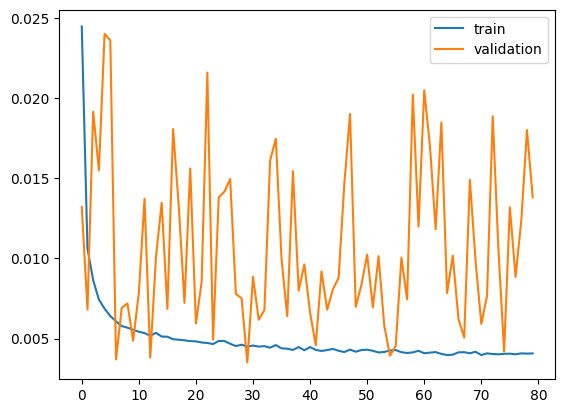

In [14]:
from models.RNN import RNN

model = RNN()  # Instantiate your model
history = model.fit(NO3_train_x,
                    NO3_train_y,
                    NO3_val_x,
                    NO3_val_y,
                    epochs=80)  # Train the model

model.evaluate(NO3_val_x, NO3_val_y)  # Validate the model

model.plot_history('models/RNN_NO3_50epochs_history.png')  # Visualize training and validation loss

model.save('models/RNN_NO3_50epochs.keras')  # Save the model


In [15]:
from keras.models import load_model

# Load the model
model = load_model('models/RNN_NO3_50epochs.keras')

In [16]:
print(NO3_test_x.shape)
print(NO3_test_y.shape)

# Generate predictions for the test set
predictions = model.predict(NO3_test_x)

# `predictions` will now contain the predicted values for each of the 24 future timesteps for each sample in `NO3_test_x`
print(predictions.shape)

# Plot the first 48 predictions and true values
import matplotlib.pyplot as plt

# Actual values, dropping the 24 timestep lag
actual_values = NO3_test_y[:, 0, :]

predicted_values = predictions[:, 0, :]

# Confirm the new shapes
print(actual_values.shape)
print(predicted_values.shape)


(8711, 24, 6)
(8711, 1, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(8711, 24, 1)
(8711, 1)
(8711, 1)


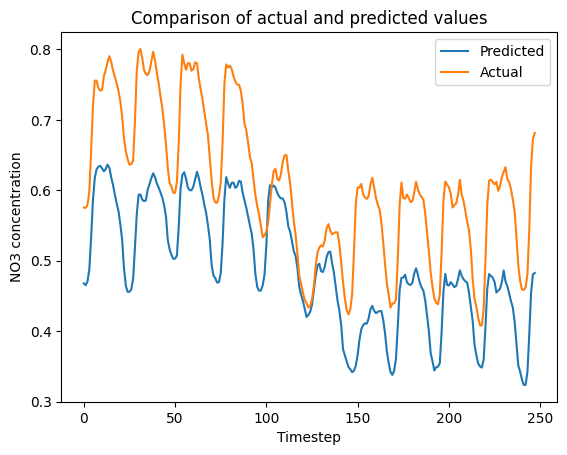

In [17]:
# Plot the first 48 predictions and true values
plt.plot(predicted_values[:248], label='Predicted')
plt.plot(actual_values[:248], label='Actual')
plt.title('Comparison of actual and predicted values')
plt.ylabel('NO3 concentration')
plt.xlabel('Timestep')
plt.legend()
plt.show()

In [18]:
import matplotlib.pyplot as plt

def predict_and_update(model, test_x, test_y, start=24, end=48, scaler=NO3scaler):
    test_x_copy = test_x[start-24:end].copy()
    test_y_copy = test_y[start-24:end].copy()
    test_x_copy[start + 1:, -1] = 0
    predictions = []
    for i in range(24, len(test_y_copy)):
        prediction = model.predict(test_x_copy[i].reshape(1, -1), verbose=0)
        predictions.append(prediction[0][0])
        if i < len(test_x_copy)-1:
            test_x_copy[i+1, -1] = prediction
    
    # Rescale the data to original values
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(-1)
    test_y_copy = scaler.inverse_transform(test_y_copy.reshape(-1, 1)).reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(test_y_copy, label='actual')
    plt.plot(range(24, len(test_y_copy)), predictions, label='predictions') 
    plt.legend()
    plt.show()

# test the function
predict_and_update(model, NO3_test_x, NO3_test_y)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None